# <center>Self Driving Car

<img src="https://www.nvidia.com/content/dam/en-zz/es_em/Solutions/self-driving-cars/home/nvidia-self-driving-car-drive-px-overview-social-image.jpg">
<center>Credits to the owner of the image</center>


## About The Project
- This project is the implementation of this [Nvidia paper](https://arxiv.org/pdf/1604.07316.pdf), with modifications as per the hardware constraints.
- We try to build a minimal version of a self driving car.
- For this project:
  - The dataset can be downloaded from [here](https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view). <br> (Credits to [Sully Chen](https://github.com/SullyChen/Autopilot-TensorFlow) for providing the dataset for educational purposes) 
  - The dataset contains:
    - 45,406 front camera view images
      - Each image contains the steering angle
- To build this project, we build a Convolution Neural Network, a deep learning architecture, model.
- Using this model, the computer predicts the steering angle to avoid all sorts of collisions.



## How Steering Angle Is Predicted?

- Predicting steering angle can be thought of as a regression problem.
- We feed in images to the model and the label to the images is the steering angle in that image.
- Model learns the steering angle as per the turns in the image and finally predicts the steering angle for unknown images.


 

![GIF](car.gif)

### Loading Necessary Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc
import tensorflow as tf

## 1. Reading images from file

In [ ]:
DATA_FOLDER = "/content/driving_dataset"
DATA_FILE = os.path.join(DATA_FOLDER, "data.txt")

x = []
y = []

train_batch_pointer = 0
test_batch_pointer = 0

In [ ]:
with open(DATA_FILE) as f:
    for line in f:
        image_name, angle = line.split()
        
        image_path = os.path.join(DATA_FOLDER, image_name)
        x.append(image_path)
        
        angle_radians = float(angle) * (pi / 180)  #converting angle into radians
        y.append(angle_radians)
y = np.array(y)
print(str(len(x))+" "+str(len(y)))

45406 45406


- We split the dataset, on temporal basis, into train and test in a ratio of 80:20

In [ ]:
split_ratio = int(len(x) * 0.8)

train_x = x[:split_ratio]
train_y = y[:split_ratio]

test_x = x[split_ratio:]
test_y = y[split_ratio:]

len(train_x), len(train_y), len(test_x), len(test_y)

(36324, 36324, 9082, 9082)

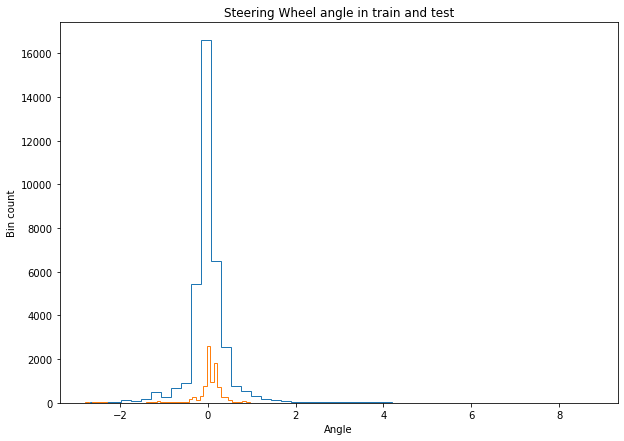

In [ ]:
fig = plt.figure(figsize = (10, 7))
plt.hist(train_y, bins = 50, histtype = "step")
plt.hist(test_y, bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

- The above histogram plot clearly shows that most of the angle values are 0.
- This is obvious as most of the time the car does not take turns and runs on a straight road.
- Therefore, steering wheel angle is 0 most of the time during the drive.

## 2. Writing function for creating batch of images for training

In [ ]:
def loadTrainBatch(batch_size):
    global train_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(train_x[(train_batch_pointer + i) % len(train_x)]) #here % len(train_x) is used to make sure that
        #"train_batch_pointer + i" should not cross the number of train images. As soon as the value of "train_batch_pointer" is
        #equal to number of train images then it will again start reading the train images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(train_y[(train_batch_pointer + i) % len(train_y)]) #appending corresponding labels
        
    train_batch_pointer += batch_size
        
    return x_result, y_result

In [ ]:
def loadTestBatch(batch_size):
    global test_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(test_x[(test_batch_pointer + i) % len(test_x)]) #here % len(test_x) is used to make sure that
        #"test_batch_pointer + i" should not cross the number of test images. As soon as the value of "test_batch_pointer" is
        #equal to number of test images then it will again start reading the test images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(test_y[(test_batch_pointer + i) % len(test_y)]) #appending corresponding labels
        
    test_batch_pointer += batch_size
        
    return x_result, y_result

## 3. Making Model Architecture

In [ ]:
def weightVariable(shape):
    initial = tf.random.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(initial) 

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def convolution(previous_input, filter_input, strides):
    return tf.nn.conv2d(previous_input, filter_input, strides = [1, strides, strides, 1], padding = "VALID")

In [ ]:
tf.compat.v1.disable_eager_execution()

x_input = tf.compat.v1.placeholder(tf.float32, shape = [None, 66, 200, 3], name = "Plc_1")
y_true = tf.compat.v1.placeholder(tf.float32, name = "Plc_2")

input_image = x_input

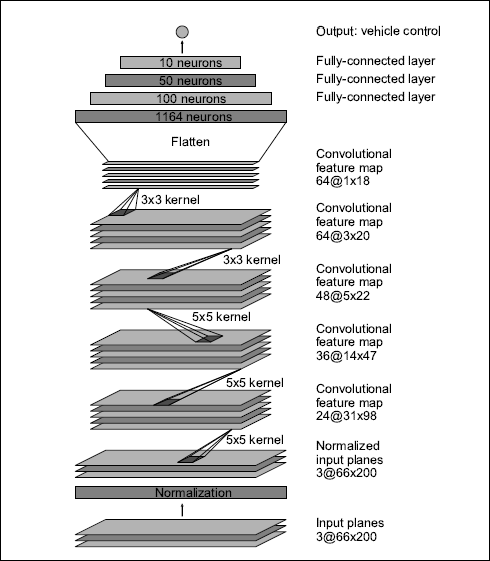

In [ ]:
from IPython.display import Image

Image('Model_Architecture.PNG')

In [ ]:
#Convolution Layers
#First convolution layer
W_Conv1 = weightVariable([5,5,3,24])
B_Conv1 = bias_variable([24])
Conv1 = tf.nn.relu(convolution(input_image, W_Conv1, 2) + B_Conv1)
#strides = 2
#Output size: 31*98*24

#Second convolution layer
W_Conv2 = weightVariable([5,5,24,36])
B_Conv2 = bias_variable([36])
Conv2 = tf.nn.relu(convolution(Conv1, W_Conv2, 2) + B_Conv2)
#strides = 2
#Output size: 14*47*36

#Third convolution layer
W_Conv3 = weightVariable([5,5,36,48])
B_Conv3 = bias_variable([48])
Conv3 = tf.nn.relu(convolution(Conv2, W_Conv3, 2) + B_Conv3)
#strides = 2
#Output size: 5*22*48

#Fourth convolution layer
W_Conv4 = weightVariable([3,3,48,64])
B_Conv4 = bias_variable([64])
Conv4 = tf.nn.relu(convolution(Conv3, W_Conv4, 1) + B_Conv4)
#strides = 1
#Output size: 3*20*64


#Fifth convolution layer
W_Conv5 = weightVariable([3,3,64,64])
B_Conv5 = bias_variable([64])
Conv5 = tf.nn.relu(convolution(Conv4, W_Conv5, 1) + B_Conv5)
#strides = 1
#Output size: 1*18*64

#Fully-Connected Dense Layers
keep_prob = tf.compat.v1.placeholder(tf.float32)
#First FC-Dense
#Input = 1*18*64 = 1152
W_FC1 = weightVariable([1152, 1164])
B_FC1 = bias_variable([1164])
FC1_Flatten = tf.reshape(Conv5, [-1, 1152]) #here, -1 indicates 1. It means that the shape of FC1_Flatten will be 1*1152
Output_FC1 = tf.nn.relu(tf.matmul(FC1_Flatten, W_FC1) + B_FC1) #so, here shape of FC1_Flatten is 1*1152 and shape of W_FC1 will
#be 1152*1164. Therefore, there will be a matrix multiplication of matrices: (1*1152) * (1152*1164) = (1*1164).
Output_FC1_drop = tf.nn.dropout(Output_FC1, 1 - (keep_prob))

#Second FC-Dense
#Input = 1*1164 = 1164
W_FC2 = weightVariable([1164, 100])
B_FC2 = bias_variable([100])
Output_FC2 = tf.nn.relu(tf.matmul(Output_FC1_drop, W_FC2) + B_FC2) #so, here shape of Output_FC1_drop is 1*1164 and shape of
#W_FC2 will be 1164*100. Therefore, there will be a matrix multiplication of matrices: (1*1164) * (1164*100) = (1*100).
Output_FC2_drop = tf.nn.dropout(Output_FC2, 1 - (keep_prob))

#Third FC-Dense
#Input = 1*100 = 100
W_FC3 = weightVariable([100, 50])
B_FC3 = bias_variable([50])
Output_FC3 = tf.nn.relu(tf.matmul(Output_FC2_drop, W_FC3) + B_FC3) #so, here shape of Output_FC2_drop is 1*100 and shape of
#W_FC3 will be 100*50. Therefore, there will be a matrix multiplication of matrices: (1*100) * (100*50) = (1*50).
Output_FC3_drop = tf.nn.dropout(Output_FC3, 1 - (keep_prob))

#Fourth FC-Dense
#Input = 1*50 = 50
W_FC4 = weightVariable([50, 10])
B_FC4 = bias_variable([10])
Output_FC4 = tf.nn.relu(tf.matmul(Output_FC3_drop, W_FC4) + B_FC4) #so, here shape of Output_FC3_drop is 1*50 and shape of
#W_FC4 will be 50*10. Therefore, there will be a matrix multiplication of matrices: (1*50) * (50*10) = (1*10).
Output_FC4_drop = tf.nn.dropout(Output_FC4, 1 - (keep_prob))

#Final Output to one neuron with linear/identity function
#Input = 1*10 = 10
W_FC5 = weightVariable([10, 1])
B_FC5 = bias_variable([1])
y_predicted = tf.identity(tf.matmul(Output_FC4_drop, W_FC5) + B_FC5) #so, here shape of Output_FC4_drop is 1*10 and shape of
#W_FC5 will be 10*1. Therefore, there will be a matrix multiplication of matrices: (1*10) * (10*1) = (1*1). Since, this is a
#regression problem so we have applied identity fuction in the end. We can also apply "atan" function here. If computational
#power is available then the model should be tested with both identity and atan functions. In the end, that function should be
#considered which gives better result.

## 4. Training the model

In [ ]:
SAVEDIR = "/content/"
sess = tf.compat.v1.InteractiveSession()

L2NormConst = 0.001
train_vars = tf.compat.v1.trainable_variables() #it will return all the variables. Here, all the weights and biases are variables which
#are trainable.

loss = tf.reduce_mean(input_tensor=tf.square(tf.subtract(y_true, y_predicted))) + tf.add_n([tf.nn.l2_loss(w) for w in train_vars]) * L2NormConst
#since this is a regression problem so above loss is mean-squared-error loss
train_step = tf.compat.v1.train.AdamOptimizer(learning_rate = 10**-4).minimize(loss)
sess.run(tf.compat.v1.global_variables_initializer())

saver = tf.compat.v1.train.Saver()

epochs = 30
batch_size = 100
epoch_number, train_loss, test_loss,  = [], [], []

for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    te_loss_old = 10000  #any big number can be given

    for i in range(int(len(x)/batch_size)):
        train_batch_x, train_batch_y = loadTrainBatch(batch_size)
        train_step.run(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 0.8})
        tr_loss = loss.eval(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 1.0})
        train_avg_loss += tr_loss / batch_size

        test_batch_x, test_batch_y = loadTestBatch(batch_size)
        te_loss_new = loss.eval(feed_dict = {x_input: test_batch_x, y_true: test_batch_y, keep_prob: 1.0})
        test_avg_loss += te_loss_new / batch_size

        if te_loss_new < te_loss_old:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {} *".format(epoch+1, tr_loss, te_loss_new))
        else:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {}".format(epoch+1, tr_loss, te_loss_new))
        te_loss_old = te_loss_new

        if (i+1) % batch_size == 0:
            if not os.path.exists(SAVEDIR):
                os.makedirs(SAVEDIR)
            save_path = os.path.join(SAVEDIR, "model.ckpt")
            saver.save(sess = sess, save_path = save_path)
            print("Model saved at location {} at epoch {}".format(save_path, epoch + 1))

    epoch_number.append(epoch)
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)

#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
log_frame["Epoch"] = epoch_number
log_frame["Train Loss"] = train_loss
log_frame["Test Loss"] = test_loss
log_frame.to_csv(os.path.join(SAVEDIR, "log.csv"), index = False)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Streaming output truncated to the last 5000 lines.
Epoch: 20, Train_Loss: 0.19020037353038788, Test_Loss: 0.17120352387428284 *
Epoch: 20, Train_Loss: 0.17305819690227509, Test_Loss: 0.19257375597953796
Epoch: 20, Train_Loss: 0.17192746698856354, Test_Loss: 0.22207877039909363
Epoch: 20, Train_Loss: 0.16906434297561646, Test_Loss: 0.22516272962093353
Epoch: 20, Train_Loss: 0.17275111377239227, Test_Loss: 0.17061832547187805 *
Epoch: 20, Train_Loss: 0.22686760127544403, Test_Loss: 0.18268564343452454
Epoch: 20, Train_Loss: 0.19112130999565125, Test_Loss: 0.19608306884765625
Epoch: 20, Train_Loss: 0.1687539964914322, Test_Loss: 0.23193839192390442
Epoch: 20, Train_Loss: 0.16830934584140778, Test_Loss: 0.18779677152633667 *
Epoch: 20, Train_Loss: 0.18146692216396332, Test_Loss: 0.2569132149219513
Epoch: 20, Train_Loss: 0.17976297438144684, Test_Loss: 0.1975480318069458 *
Epoch: 20, Train_Loss: 0.1640138179063797, Test_Loss: 0.227186381816864
Epoch: 20, Train_Loss: 0.16033188998699188, Tes

In [ ]:
frame = pd.read_csv(os.path.join(SAVEDIR, "log.csv"))
frame

Epoch  Train Loss  Test Loss
0       0   25.434909  24.962961
1       1   17.130709  16.235739
2       2   11.683126  11.185580
3       3    8.464392   8.123377
4       4    6.683632   6.206376
5       5    5.779707   4.935818
6       6    4.556098   4.073516
7       7    3.748937   3.431343
8       8    3.406691   2.973092
9       9    3.385583   2.579671
10     10    2.767768   2.314111
11     11    2.419604   2.120536
12     12    2.371616   1.967942
13     13    2.590183   1.863760
14     14    2.213160   1.786208
15     15    1.916511   1.753011
16     16    1.985815   1.673910
17     17    2.164690   1.663195
18     18    1.845667   1.694987
19     19    1.615989   1.646570
20     20    1.687884   1.566176
21     21    1.943641   1.535583
22     22    1.679983   1.605736
23     23    1.500983   1.419459
24     24    1.553415   1.382033
25     25    1.808064   1.463120
26     26    1.565051   1.566114
27     27    1.392387   1.404519
28     28    1.414948   1.436822
29     29    1.638543   1.500023

## 5. Making Predictions from the Model

INFO:tensorflow:Restoring parameters from /content/model.ckpt


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


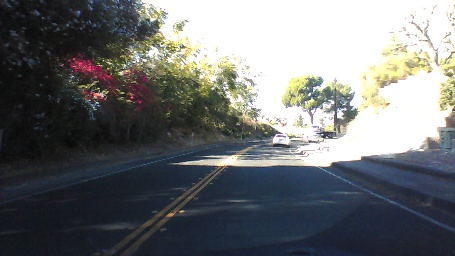

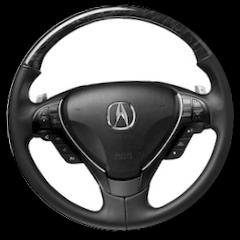

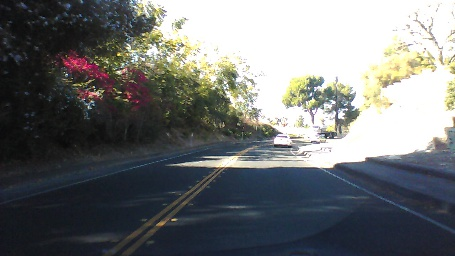

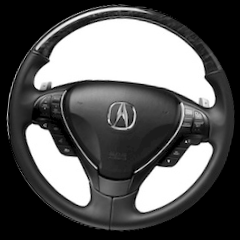

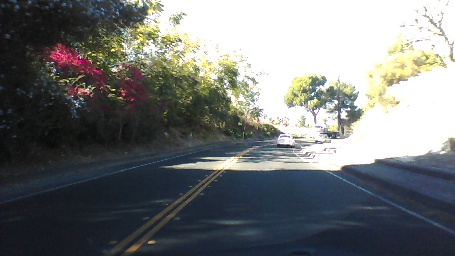

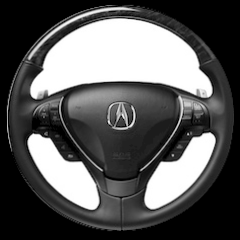

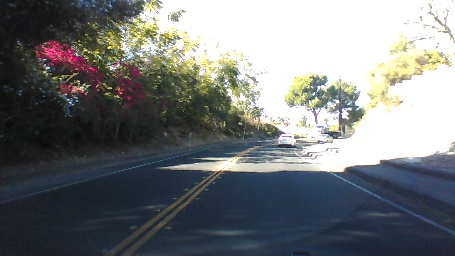

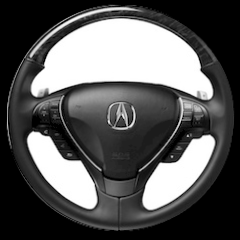

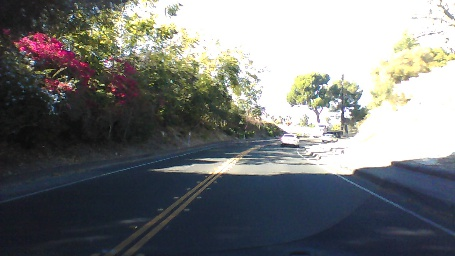

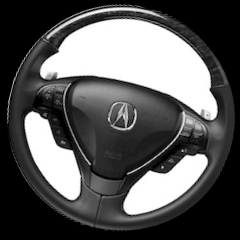

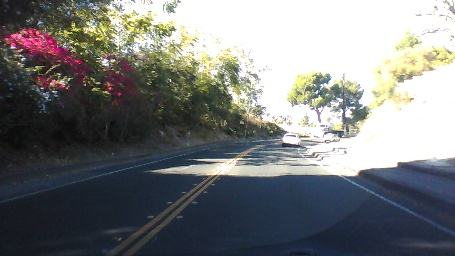

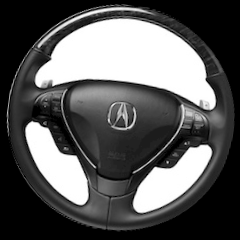

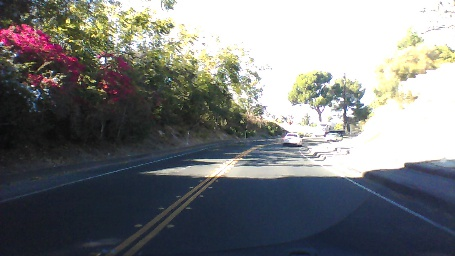

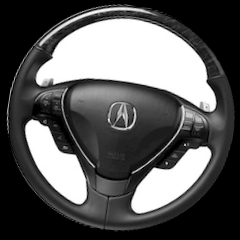

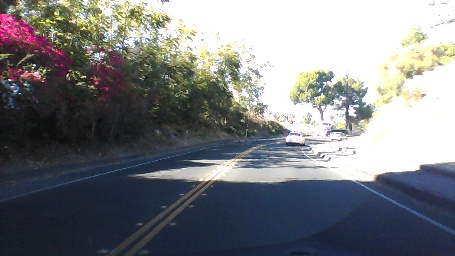

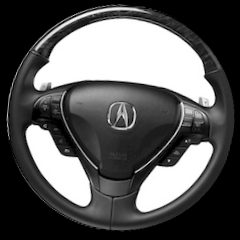

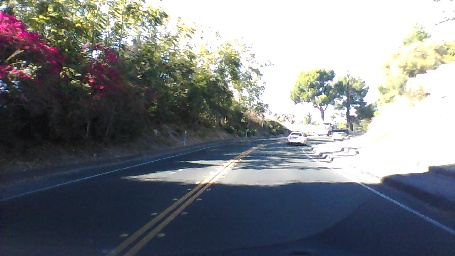

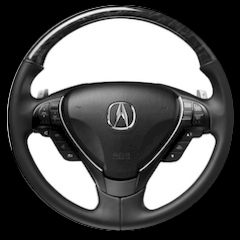

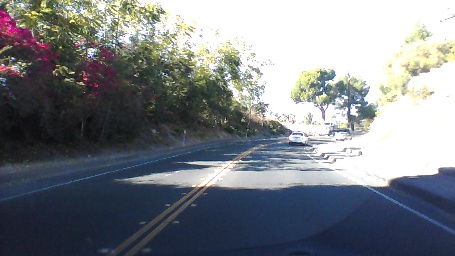

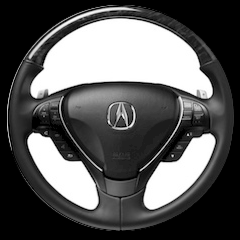

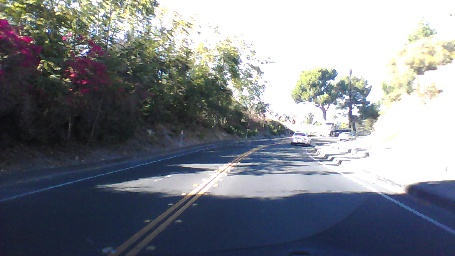

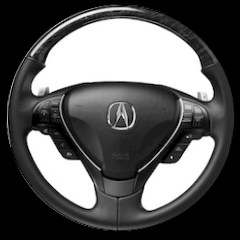

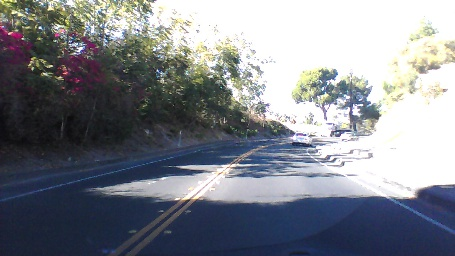

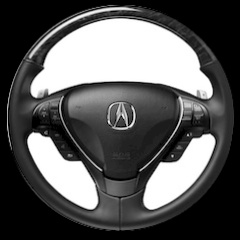

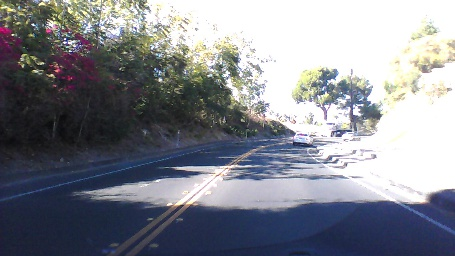

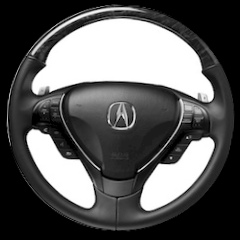

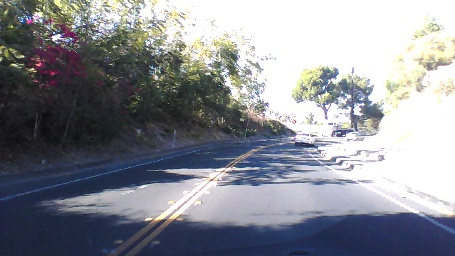

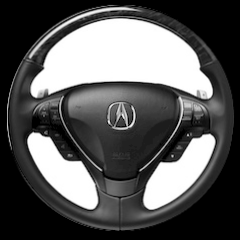

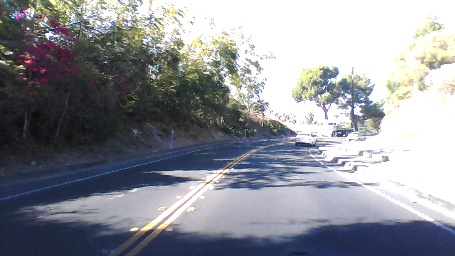

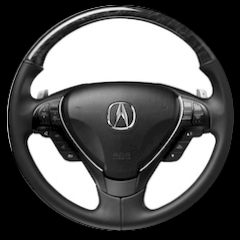

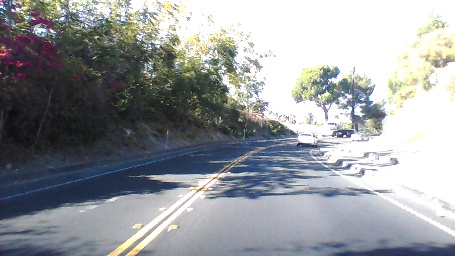

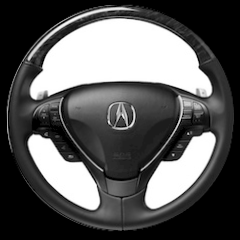

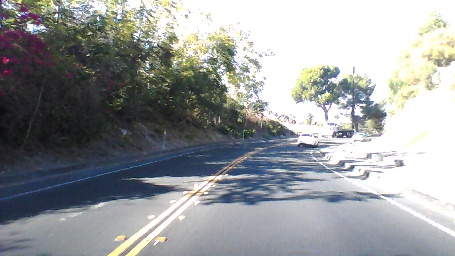

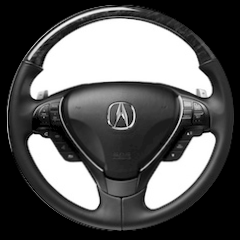

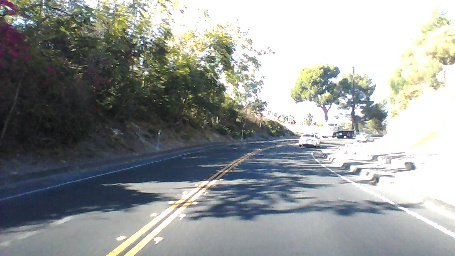

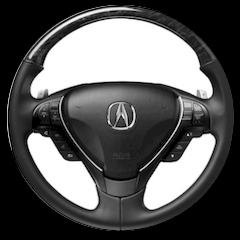

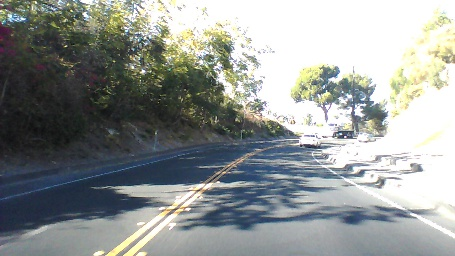

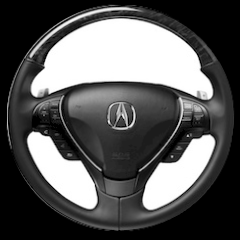

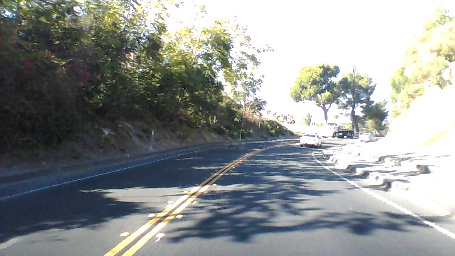

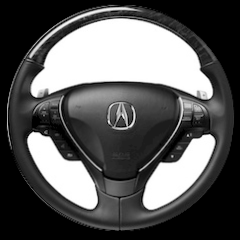

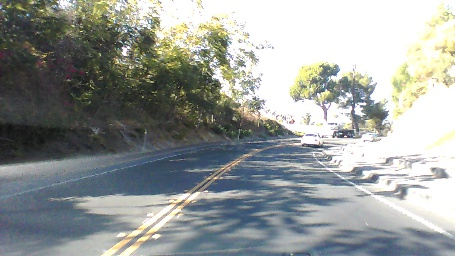

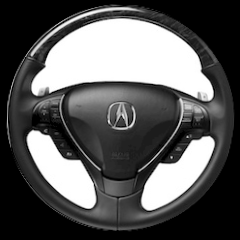

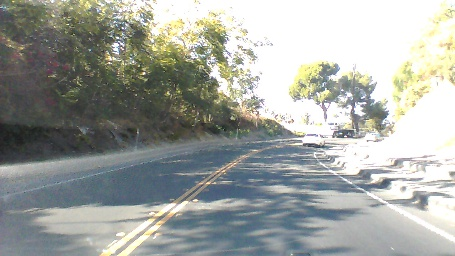

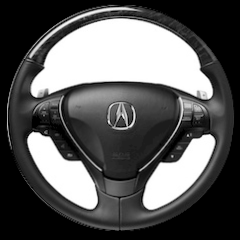

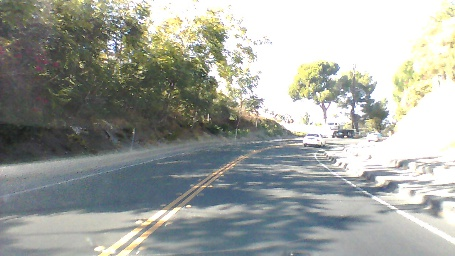

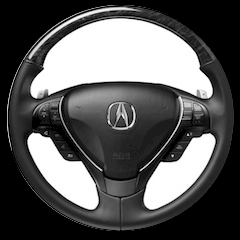

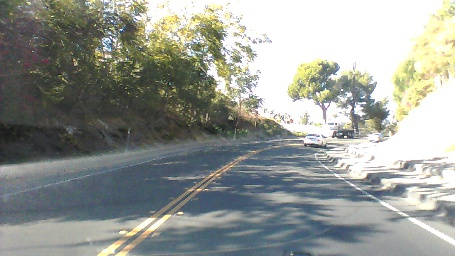

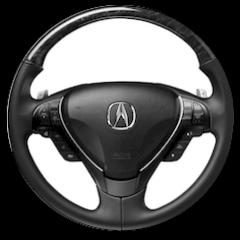

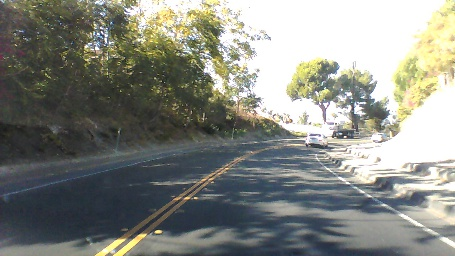

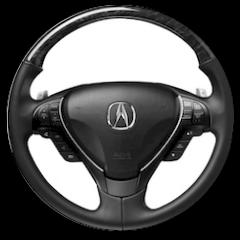

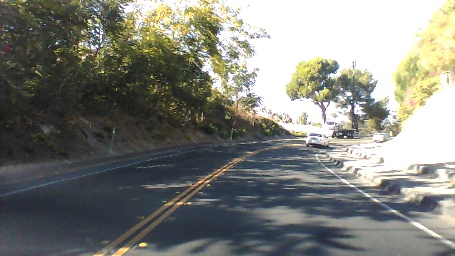

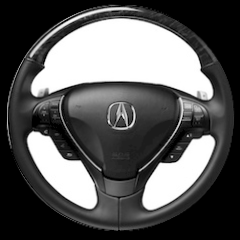

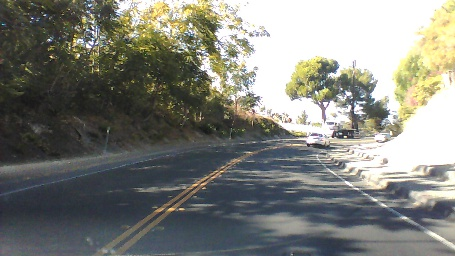

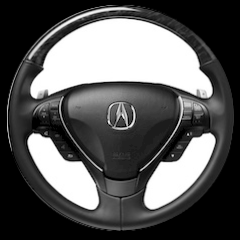

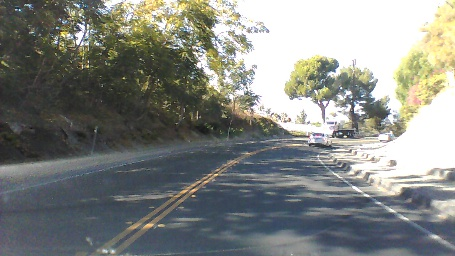

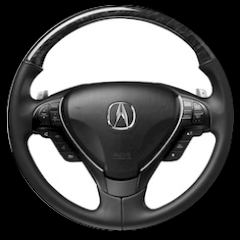

In [ ]:
from google.colab.patches import cv2_imshow

sess = tf.compat.v1.InteractiveSession()
saver = tf.compat.v1.train.Saver()
saver.restore(sess, "/content/model.ckpt")

img = cv2.imread('/content/steering_wheel_image.jpg', 0) #here, second parameter '0' specifies that img.shape will return only height and
#width of the image and not the number of channels. It is a colored image so number of channels = 3, which it will not return.
rows, cols = img.shape

i = 0
while(cv2.waitKey(60) != ord("q")):
    full_image = cv2.imread(test_x[i])
    cv2_imshow(full_image) #cv2.imshow('Frame Window', full_image) when using in PC.
    image = ((cv2.resize(full_image[-150:], (200, 66)) / 255.0).reshape((1, 66, 200, 3)))
    degrees = sess.run(y_predicted, feed_dict = {x_input: image, keep_prob: 1.0})[0][0] *180 / pi #here, we have converted the
    #predicted degrees from radians to degrees.
    M = cv2.getRotationMatrix2D((cols/2,rows/2), -degrees, 1) #this function rotate the image by a given degrees.
    dst = cv2.warpAffine(src = img, M = M, dsize = (cols, rows)) #warpAffine function applies rotation to the image
    cv2_imshow(dst) #cv2.imshow("Steering Wheel", dst) when using in PC.
    i += 1

cv2.destroyAllWindows()

### Run the "run_self_driving_car.py" file in the command prompt to visualize the output better.